In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import pandas as pd
import numpy as np
import time
import re
import string
import copy
import operator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TreebankWordTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from collections import OrderedDict, Counter

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import LabelPowerset


def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [2]:
class Haptik():
    def _label_converter(self, df):
        '''
        Converts labels into a binary format
        '''
        X = df.iloc[:, 0]
        y = df.iloc[:, 1:].replace({'F' : 0, 'T': 1})
        return X, y

    
    def __init__(self, path):
        '''
        Initialises the class, reads in the data, seperates targets and features
        '''
        self.path = path
        self.train = pd.read_csv(self.path+'/train_data.csv', encoding = 'utf-8')
        self.test = pd.read_csv(self.path+'/test_data.csv', encoding = 'utf-8')
        self.X_train, self.y_train = self._label_converter(self.train)
        self.X_test, self.y_test = self._label_converter(self.test)
        self.target_names = list(self.y_train.columns)

        
    def __repr__(self):
        '''
        Printable representation of the class 
        '''
        repr_str = "\nX_train_shape: {}\ny_train_shape: {}\nX_test_shape: {}\ny_test_shape: {}"\
              .format(self.X_train.shape, self.y_train.shape, self.X_test.shape, self.y_test.shape)
        return repr_str
    
    
    def _add_features(self, corpus):
        '''
        Adds useful features to improve the model
        '''
        
        # TimeofDay
        corpus = [re.sub('[0-9]{1,2} ?(am|pm)', 'timeofday', text) for text in corpus]
        
        # Minutes/hour
        corpus = [re.sub('[0-9]{1,2} ?(hours?|hrs?|mins?|minutes?)', 'durationtext', text) for text in corpus]
        
        # Phone number or pnr
        corpus = [re.sub('[0-9]{10}\D', 'phoneorpnr', text) for text in corpus]
        return corpus
    
    
    def _preprocessing(self, corpus, punc=True, stem=True, rm_words=[]):
        """
        Takes in a string of text, then performs the following:
        1. Remove all punctuation
        2. Removes text in between curly braces (internal haptik data)
        3. Remove all stopwords and custom defined words
        4. Performs stemming
        5. Returns a list of the cleaned text
        """

        p_stemmer = PorterStemmer()
        tokenizer = TreebankWordTokenizer()
        remove_words = get_stop_words('en') + rm_words
        
        # Remove text between curly braces as they may not be present in actual data
        corpus = [re.sub('{.+}', '', text) for text in corpus]
        
        # Replace punctuation with space
        corpus = [re.sub('[{}]'.format(re.escape(string.punctuation)), ' ', text) for text in corpus] if punc else corpus

        # Tokenize
        corpus = [row.lower() for row in corpus]
        corpus = [tokenizer.tokenize(row) for row in corpus]

        # Remove Stopwords and custom defined words
        corpus = [[word for word in text if word not in remove_words] for text in corpus]

        # Stemmer
        corpus = [[p_stemmer.stem(word) for word in text] for text in corpus] if stem else corpus

        return corpus
    
    
    @timeit
    def preprocess(self, **param_pre):
        """
        Adds features and performs preprocessing on train and test data
        """
        
        self.X_train = self._add_features(self.X_train)
        self.X_test = self._add_features(self.X_test)
        self.X_train = pd.Series(self._preprocessing(self.X_train, **param_pre))
        self.X_test = pd.Series(self._preprocessing(self.X_test, **param_pre))
        return self
    
    
    @timeit
    def classify(self, model, cv=False):
        """
        Classifier does :
        1. Vectorization i.e., converts messages to a matrix of word counts
        2. Stratified Cross-Validation
        3. Takes a model and fits it on the Document Term Matrix obtained by vectorization
        4. Calculates subset accuracy and generates classification report
        """
        
        X_train = copy.deepcopy(self.X_train)
        X_test = copy.deepcopy(self.X_test)
        y_train = copy.deepcopy(self.y_train)
        y_test = copy.deepcopy(self.y_test)
        
        vect = CountVectorizer(ngram_range=(1, 2), analyzer=lambda doc:doc)
        X_train_dtm = vect.fit_transform(X_train)
        X_test_dtm = vect.transform(X_test)
        
        # token frequency count
        freq = np.ravel(X_train_dtm.sum(axis=0))
        vocab = [v[0] for v in sorted(vect.vocabulary_.items(), key=operator.itemgetter(1))]
        self.freq_sorted = dict(zip(vocab, freq))
        
        # Cross Validation
        if cv:
            self._crossvalidation(X_train_dtm, y_train, model)
        
        model.fit(X_train_dtm, y_train)
        y_pred = model.predict(X_test_dtm)
        
        self.accuracy = accuracy_score(y_test, y_pred)
        self.report = classification_report(y_test, y_pred, target_names=self.target_names)
        
    
    @timeit
    def _crossvalidation(self, X_train_dtm, y_train, model):
        """
        Performs a three fold Stratified Cross-Validation
        """
        
        kf = StratifiedKFold(n_splits=3, random_state=7, shuffle=True)
        lp = LabelPowerset()
        self.cv_acc = []

        for train_index, test_index in kf.split(X_train_dtm, lp.transform(y_train)):
            X_train_cv = X_train_dtm[train_index,:]
            y_train_cv = y_train.loc[train_index,:]

            X_test_cv = X_train_dtm[test_index,:]
            y_test_cv = y_train.loc[test_index,:]

            model.fit(X_train_cv, y_train_cv)
            predictions = model.predict(X_test_cv)

            self.cv_acc.append(accuracy_score(y_test_cv, predictions))

In [3]:
hp = Haptik('../data/').preprocess()

'preprocess'  15144.90 ms


In [4]:
hp.classify(model=OneVsRestClassifier(LinearSVC()))

'classify'  9440.95 ms


## EDA

In [5]:
hp


X_train_shape: (40659,)
y_train_shape: (40659, 9)
X_test_shape: (10000,)
y_test_shape: (10000, 9)

In [6]:
# Average length of messages
all_words = TreebankWordTokenizer().tokenize(hp.train['message'].sum())
avg_len = len(all_words)/hp.X_train.shape[0]
print('Average length in words {}'.format(avg_len))

Average length in words 6.88285496446


In [7]:
# No of rows with single labels
hp.y_train[hp.y_train.sum(axis=1) <= 1].shape

(36993, 9)

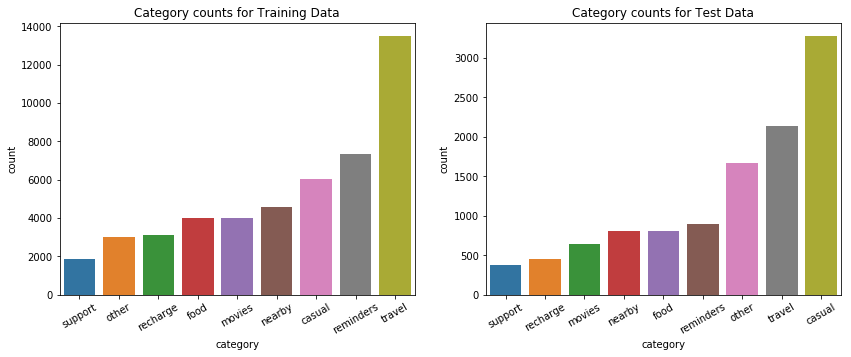

In [8]:
category_counts_train = hp.y_train.sum(axis=0).reset_index().rename(columns={'index': 'category', 0: 'count'}).sort_values('count')
category_counts_test = hp.y_test.sum(axis=0).reset_index().rename(columns={'index': 'category', 0: 'count'}).sort_values('count')

plt.figure(figsize=(14,5))
plt.subplot(121)
sns.barplot(x='category', y='count', data=category_counts_train)
plt.xticks(rotation=30)
plt.title('Category counts for Training Data')

plt.subplot(122)
sns.barplot(x='category', y='count', data=category_counts_test)
plt.xticks(rotation=30)
plt.title('Category counts for Test Data')

In [9]:
# Word counts before preprocessing
all_words = TreebankWordTokenizer().tokenize(hp.train['message'].sum())
word_counts = Counter(all_words)
pd.DataFrame({'word': word_counts.keys(), 'count':word_counts.values()}).sort_values('count', axis=0, ascending=False)

,count,word
24069,10431,to
39955,8049,","
36175,7358,:
11800,5754,for
16712,5395,i
33424,4816,?
19874,4744,me
14502,3948,the
19894,3600,my
17402,3202,in


In [10]:
# WordCount after preprocessing
all_words = hp.X_train.sum()
word_counts = Counter(all_words)
pd.DataFrame({'word': word_counts.keys(), 'count':word_counts.values()}).sort_values('count', axis=0, ascending=False)

,count,word
807,4154,remind
5020,3661,can
2825,3468,timeofday
200,3266,want
9690,2190,u
9372,1953,cancel
15423,1846,book
10806,1721,train
14560,1690,pleas
7211,1654,need


In [11]:
# WordCount in Final Dtm
wc = pd.DataFrame({'word': hp.freq_sorted.keys(), 'count':hp.freq_sorted.values()}).sort_values('count', axis=0, ascending=False)
wc

,count,word
786,4154,remind
5002,3661,can
2815,3468,timeofday
190,3266,want
11566,2190,u
9350,1953,cancel
15426,1846,book
10793,1721,train
14832,1690,pleas
12265,1654,need


## Binary Relevance

In [67]:
hp.classify(model=OneVsRestClassifier(LinearSVC()), cv=True)

/home/mudassir/anaconda2/envs/greyatom/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


'_crossvalidation'  9795.85 ms
'classify'  18086.83 ms


In [68]:
print("Subset Accuracy: {:.2f}%\n".format(hp.accuracy*100))
print(hp.report)

Subset Accuracy: 73.95%

             precision    recall  f1-score   support

       food       0.85      0.61      0.71       810
   recharge       0.77      0.67      0.72       450
    support       0.68      0.38      0.49       371
  reminders       0.88      0.82      0.85       893
     travel       0.82      0.86      0.84      2138
     nearby       0.65      0.62      0.63       807
     movies       0.81      0.57      0.67       637
     casual       0.86      0.84      0.85      3282
      other       0.89      0.64      0.75      1668

avg / total       0.83      0.74      0.78     11056



In [69]:
print("Cross-validated accuracy: {}".format(hp.cv_acc))

Cross-validated accuracy: [0.69899837973191925, 0.70025839793281652, 0.70035460992907805]


# RandomForest

In [33]:
hp.classify(model=RandomForestClassifier(n_estimators=100, random_state=7), cv=False)

'classify'  186417.65 ms


In [34]:
print("Subset Accuracy: {:.2f}%\n".format(hp.accuracy*100))
print(hp.report)

Subset Accuracy: 73.11%

             precision    recall  f1-score   support

       food       0.78      0.60      0.68       810
   recharge       0.75      0.66      0.70       450
    support       0.56      0.24      0.34       371
  reminders       0.88      0.86      0.87       893
     travel       0.81      0.84      0.83      2138
     nearby       0.69      0.61      0.65       807
     movies       0.69      0.62      0.65       637
     casual       0.80      0.87      0.83      3282
      other       0.91      0.48      0.63      1668

avg / total       0.80      0.72      0.75     11056



In [72]:
print("Cross-validated accuracy: {}".format(hp.cv_acc))

Cross-validated accuracy: [0.66725585505965535, 0.67021040974529345, 0.66578014184397161]


## Label Powerset

In [28]:
hp.classify(model=LabelPowerset(LinearSVC(), require_dense=[False, False]), cv=True)

/home/mudassir/anaconda2/envs/greyatom/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


'_crossvalidation'  23130.99 ms
'classify'  39299.08 ms


In [29]:
print("Subset Accuracy: {:.2f}%\n".format(hp.accuracy*100))
print(hp.report)

Subset Accuracy: 80.51%

             precision    recall  f1-score   support

       food       0.80      0.65      0.72       810
   recharge       0.76      0.70      0.73       450
    support       0.63      0.41      0.50       371
  reminders       0.85      0.85      0.85       893
     travel       0.84      0.86      0.85      2138
     nearby       0.67      0.66      0.67       807
     movies       0.77      0.58      0.66       637
     casual       0.82      0.90      0.86      3282
      other       0.87      0.68      0.76      1668

avg / total       0.81      0.78      0.79     11056



In [30]:
print("Cross-validated accuracy: {}".format(hp.cv_acc))

Cross-validated accuracy: [0.75732803063779641, 0.75703211517165003, 0.75561465721040189]


# Way Ahead
1. Named Entity Recognition
2. Spelling Check
3. Ensembling